In [ ]:
!pip install torch transformers

In [10]:
import torch
import numpy as np
from scipy.special import softmax
from tqdm import tqdm

In [11]:
from google.colab import drive
import pandas as pd
from IPython.display import display
from google.colab import drive
drive.mount('/content/drive')
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/data/processed/random_selected_articles_summaries_gpt.csv'
df = pd.read_csv(csv_file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model.eval()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly id

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [13]:
def score_article(article):
    # Tokenize the input article
    inputs = tokenizer(article, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the logits and apply softmax to get probabilities
    scores = outputs.logits[0].numpy()
    scores = softmax(scores)

    # Get the sentiment label
    sentiment = np.argmax(scores)

    # Define sentiment labels
    labels = ['Negative', 'Neutral', 'Positive']

    return labels[sentiment], scores

# Initialize a list to store results
results = []

# Loop through articles and score them
for _, article in tqdm(df.iterrows()):
    # Score the cleaned article
    article_predicted_class, article_class_probabilities = score_article(article['cleaned_article'])

    # Score the summary
    summary_predicted_class, summary_class_probabilities = score_article(article['summary'])

    # Append results to the list
    results.append({
        "Article Title": article['title'],  # Assuming you want to use the article's title
        "Article Predicted Class": article_predicted_class,
        "Article Class Probabilities": article_class_probabilities,
        "GPT Predicted Class": summary_predicted_class,
        "GPT Class Probabilities": summary_class_probabilities
    })

# Convert the results to a DataFrame
df = pd.DataFrame(results)

# Display the results in tabular format
display(df)


293it [17:38,  3.61s/it]


,Article Title,Article Predicted Class,Article Class Probabilities,GPT Predicted Class,GPT Class Probabilities
0,Poland abortion: Polish women look for help in...,Neutral,"[0.23114845, 0.7413644, 0.027487205]",Negative,"[0.6074393, 0.37704575, 0.015514936]"
1,Hong Kong Cardinal advocates for promoting a c...,Neutral,"[0.008529517, 0.6685069, 0.32296357]",Neutral,"[0.024423804, 0.6591893, 0.31638685]"
2,Sex Education in the Philippines - The Borgen ...,Neutral,"[0.028562682, 0.8699873, 0.10145]",Neutral,"[0.072452754, 0.82158273, 0.10596457]"
3,"When a fetal scan showed problems, she fled Id...",Neutral,"[0.21159431, 0.7582101, 0.03019549]",Negative,"[0.79764026, 0.19391598, 0.008443783]"
4,Prioritizing the Neglected Areas of SRHR in Ca...,Neutral,"[0.04012358, 0.8849569, 0.074919514]",Neutral,"[0.066280365, 0.78974146, 0.14397812]"
...,...,...,...,...,...
288,Pueblo Council decision on anti-abortion ordin...,Neutral,"[0.27194136, 0.69498706, 0.033071533]",Neutral,"[0.16884212, 0.7375804, 0.093577445]"
289,Louisiana House guts abortion bill that could ...,Neutral,"[0.16884212, 0.7375804, 0.093577445]",Neutral,"[0.17956343, 0.73198247, 0.088454075]"
290,Onslaught of new abortion restrictions looms i...,Neutral,"[0.19652307, 0.77418995, 0.029286986]",Neutral,"[0.41336912, 0.565423, 0.02120787]"
291,Indiana abortion clinics stop providing aborti...,Neutral,"[0.11622482, 0.85728794, 0.026487205]",Negative,"[0.664443, 0.32553956, 0.010017445]"


from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Article Predicted Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('GPT Predicted Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['GPT Predicted Class'].value_counts()
    for x_label, grp in df.groupby('Article Predicted Class')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Article Predicted Class')
_ = plt.ylabel('GPT Predicted Class')

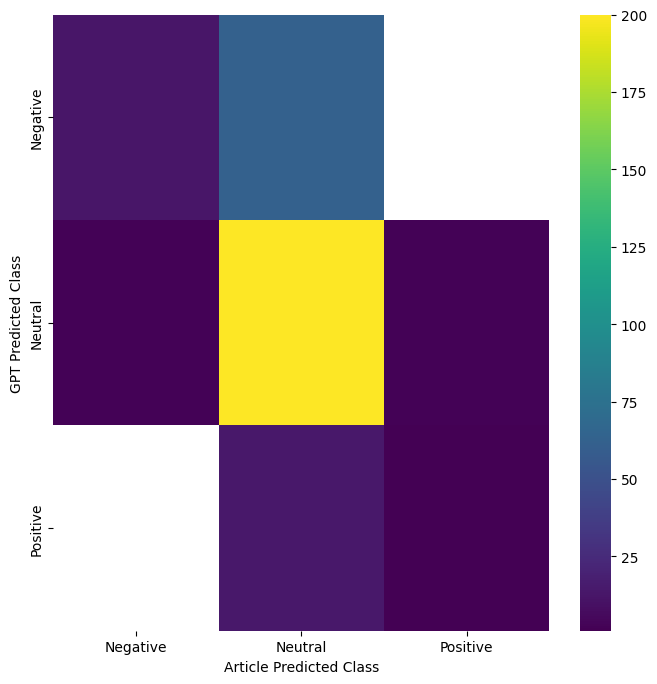

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['GPT Predicted Class'].value_counts()
    for x_label, grp in df.groupby('Article Predicted Class')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Article Predicted Class')
_ = plt.ylabel('GPT Predicted Class')

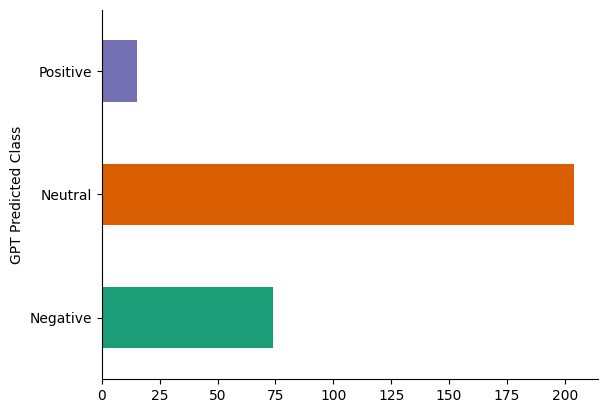

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('GPT Predicted Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

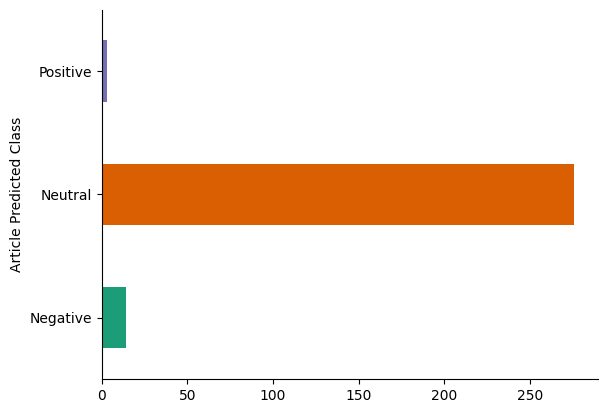

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Article Predicted Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)